# Paper CHF - 4 beats

## Setup

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.metrics import specificity_score
import time

In [2]:
THREADS_TO_USE = 4

## Load dataset

In [3]:
data = pd.read_csv('../dataset/st_dataset_4beats.csv')
data = data.dropna()
data.head()

,id,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,...,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15,cfr_16,label
0,e0106,13.102095,13.097001,13.072790,3.706391,0.542614,1.240982,-0.895934,-2.712703,-2.663057,...,-0.069056,0.062074,-0.071315,0.072003,-0.085813,0.018093,-0.024765,-0.023205,0.019933,NSR
1,e0106,17.487040,17.476616,17.514101,4.949534,0.713287,1.208352,-0.835234,-1.803925,-2.177733,...,-0.033026,0.017482,-0.014863,0.016572,-0.072260,0.024719,-0.037654,-0.001608,-0.009617,NSR
2,e0106,17.765692,18.767421,18.563219,5.234889,0.756572,1.239086,-0.727071,-1.738814,-2.078783,...,-0.036041,0.011065,-0.006174,0.017821,-0.030732,-0.027515,-0.018567,0.002476,-0.011823,NSR
3,e0106,17.472889,18.368493,18.044299,5.083577,0.745658,1.200223,-0.800412,-1.813089,-2.117043,...,-0.013610,-0.003827,-0.018916,0.046067,-0.068930,0.005377,-0.029879,0.006491,-0.021803,NSR
4,e0106,16.631755,17.107590,16.986173,4.785861,0.705577,1.207803,-0.814830,-1.677964,-1.684348,...,-0.050212,0.021235,-0.011183,0.030903,-0.061186,-0.018751,0.003333,-0.020661,0.007397,NSR


In [4]:
data['label'].replace("ST-", "ST", inplace=True)
data['label'].replace("ST+", "ST", inplace=True)

In [5]:
data['label'].value_counts()

NSR    104876
ST      31872
Name: label, dtype: int64

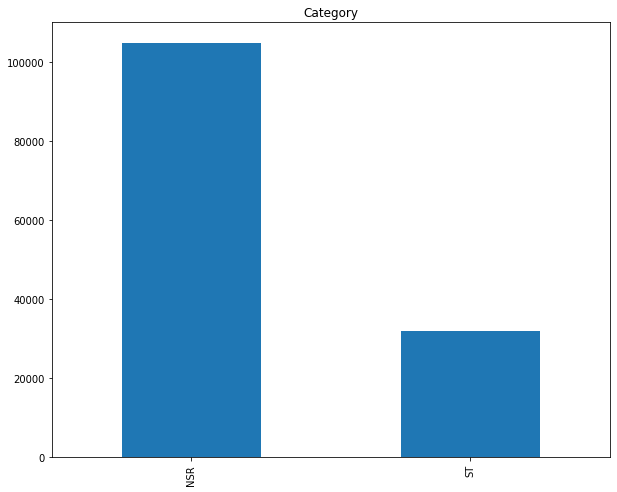

In [6]:
data['label'].value_counts().plot(kind='bar', title='Category', figsize=(10,8))
plt.show()

In [7]:
data.corr()

,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,mfw_5,...,cfr_7,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15,cfr_16
dw_1,1.000000,0.312273,0.162467,0.110289,0.114818,0.091114,-0.029557,0.006399,-0.000875,0.001703,...,-0.042191,-0.050062,-0.008514,0.005894,0.015042,-0.023458,-0.014237,-0.036773,-0.059384,-0.038783
dw_2,0.312273,1.000000,0.840060,0.440370,0.158646,0.415202,-0.437598,-0.206089,-0.003727,0.005025,...,-0.143619,0.102186,0.218697,0.162054,0.045198,0.025353,0.101591,-0.013728,-0.121356,-0.078300
dw_3,0.162467,0.840060,1.000000,0.613108,0.233954,0.305744,-0.499972,-0.269989,-0.004282,0.002581,...,-0.201584,0.090697,0.252037,0.115305,-0.043451,0.034627,0.045318,-0.033912,-0.133216,-0.044818
dw_4,0.110289,0.440370,0.613108,1.000000,0.900298,0.029004,-0.221348,-0.125818,-0.001509,0.000622,...,-0.139370,0.027890,0.115591,0.036784,-0.040897,0.031590,0.027101,-0.027459,-0.083792,-0.027346
dw_5,0.114818,0.158646,0.233954,0.900298,1.000000,-0.093747,-0.013018,-0.014289,0.000039,-0.000191,...,-0.065101,-0.007436,0.022364,0.006044,-0.015060,0.013505,0.011685,-0.024332,-0.037581,-0.015057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cfr_12,-0.023458,0.025353,0.034627,0.031590,0.013505,-0.078775,0.021517,0.061659,0.000381,0.003797,...,-0.114312,-0.205332,-0.130827,-0.012334,0.047726,1.000000,-0.024143,-0.054066,-0.277308,-0.170496
cfr_13,-0.014237,0.101591,0.045318,0.027101,0.011685,0.077259,0.004550,0.003053,-0.000895,0.001937,...,0.110173,0.020152,-0.217039,-0.265132,-0.093551,-0.024143,1.000000,0.126068,0.040084,-0.170708
cfr_14,-0.036773,-0.013728,-0.033912,-0.027459,-0.024332,0.014857,0.010542,0.014576,-0.000553,0.000869,...,0.077729,0.198416,0.039598,-0.185391,-0.289586,-0.054066,0.126068,1.000000,0.090389,-0.160650
cfr_15,-0.059384,-0.121356,-0.133216,-0.083792,-0.037581,0.017184,0.080945,0.046306,0.003503,-0.004316,...,0.231845,0.160889,-0.064172,-0.148376,-0.122505,-0.277308,0.040084,0.090389,1.000000,0.127273


In [8]:
y = data['label'].values
X = data.loc[:, ~data.columns.isin(["id", "label"])].copy()
patient_ids = data["id"].values

In [9]:
label_encoder = LabelEncoder().fit(y)
y = label_encoder.transform(y)

## Feature selection

### exclude features with corr > 0.95

In [10]:
correlated_features = set()
correlation_matrix = X.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.95:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [11]:
print(correlated_features)

{'fft_176', 'fft_132', 'fft_177', 'fft_183', 'fft_147', 'fft_189', 'fft_221', 'fft_251', 'fft_191', 'fft_151', 'fft_255', 'fft_142', 'fft_212', 'mfw_12', 'fft_219', 'fft_209', 'fft_159', 'fft_215', 'fft_213', 'fft_162', 'fft_207', 'fft_238', 'fft_156', 'fft_256', 'fft_164', 'mfw_8', 'fft_242', 'fft_133', 'fft_173', 'fft_166', 'fft_185', 'fft_175', 'fft_204', 'fft_208', 'fft_217', 'fft_135', 'mfw_15', 'fft_168', 'fft_200', 'fft_145', 'fft_137', 'fft_144', 'fft_223', 'fft_220', 'fft_205', 'fft_222', 'fft_154', 'fft_131', 'fft_199', 'fft_226', 'mfw_9', 'fft_236', 'fft_230', 'fft_136', 'fft_195', 'fft_197', 'fft_203', 'fft_237', 'fft_193', 'fft_152', 'fft_192', 'fft_243', 'fft_169', 'fft_250', 'fft_186', 'fft_241', 'fft_239', 'fft_178', 'fft_181', 'fft_180', 'fft_211', 'fft_233', 'fft_130', 'fft_227', 'fft_172', 'fft_254', 'fft_157', 'fft_194', 'fft_228', 'fft_167', 'mfw_5', 'fft_171', 'fft_165', 'fft_202', 'fft_160', 'fft_188', 'fft_155', 'fft_158', 'fft_184', 'mfw_13', 'fft_234', 'fft_14

### Random forest embeded for features selection

In [12]:
cols_no_corr = [col for col in X.columns if col not in correlated_features]

In [13]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(random_state=101, n_jobs=THREADS_TO_USE), threshold='1.25*median')
embeded_rf_selector.fit(X[cols_no_corr], y)

SelectFromModel(estimator=RandomForestClassifier(n_jobs=4, random_state=101),
                threshold='1.25*median')

In [14]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X[cols_no_corr].loc[:,embeded_rf_support].columns.tolist()

print('\n'.join(embeded_rf_feature), '\nselected features:', len(embeded_rf_feature))

dw_1
dw_2
dw_3
dw_4
dw_5
mfw_1
mfw_2
mfw_3
mfw_4
fft_1
fft_2
fft_3
fft_4
fft_5
fft_6
fft_7
fft_8
fft_9
fft_10
fft_11
fft_12
fft_13
fft_14
fft_15
fft_16
fft_17
fft_18
fft_19
fft_20
fft_21
fft_22
fft_23
fft_24
fft_25
fft_26
fft_27
fft_28
fft_29
fft_30
fft_31
fft_32
fft_33
fft_34
fft_35
fft_36
fft_37
fft_38
fft_39
fft_40
ar_1
ar_2
ar_3
ar_4
ar_5
ar_6
ar_7
ar_8
ar_9
ar_10
ar_16
var
cfr_1
cfr_2
cfr_3
cfr_4
cfr_5
cfr_6
cfr_7
cfr_8
cfr_9
cfr_10
cfr_11
cfr_12
cfr_13
cfr_14
cfr_15 
selected features: 76


### Visualization best features

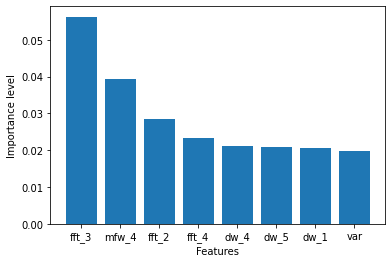

In [15]:
features_dict = dict(zip(cols_no_corr, embeded_rf_selector.estimator_.feature_importances_))
features_dict = dict(sorted(features_dict.items(), key=lambda item: item[1], reverse=True))

best_features = dict()
for index, (key, value) in enumerate(features_dict.items()):
    if index < 8:
        best_features[key] = value

plt.bar(range(len(best_features)), list(best_features.values()), align='center', )
plt.xticks(ticks=range(len(best_features)), labels=best_features.keys())
plt.xlabel('Features')
plt.ylabel('Importance level')
plt.show()

## Filter features

In [16]:
X_fsel = X[embeded_rf_feature]
X_fsel.head()

,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,fft_1,...,cfr_6,cfr_7,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15
0,13.102095,13.097001,13.072790,3.706391,0.542614,1.240982,-0.895934,-2.712703,-2.663057,0.294201,...,-0.013426,0.064171,-0.069056,0.062074,-0.071315,0.072003,-0.085813,0.018093,-0.024765,-0.023205
1,17.487040,17.476616,17.514101,4.949534,0.713287,1.208352,-0.835234,-1.803925,-2.177733,-1.533708,...,0.016671,0.036579,-0.033026,0.017482,-0.014863,0.016572,-0.072260,0.024719,-0.037654,-0.001608
2,17.765692,18.767421,18.563219,5.234889,0.756572,1.239086,-0.727071,-1.738814,-2.078783,-0.720965,...,0.020868,0.035213,-0.036041,0.011065,-0.006174,0.017821,-0.030732,-0.027515,-0.018567,0.002476
3,17.472889,18.368493,18.044299,5.083577,0.745658,1.200223,-0.800412,-1.813089,-2.117043,0.838703,...,0.026449,0.028665,-0.013610,-0.003827,-0.018916,0.046067,-0.068930,0.005377,-0.029879,0.006491
4,16.631755,17.107590,16.986173,4.785861,0.705577,1.207803,-0.814830,-1.677964,-1.684348,-0.600837,...,-0.015116,0.060441,-0.050212,0.021235,-0.011183,0.030903,-0.061186,-0.018751,0.003333,-0.020661


## Random Forest - L1SO

In [17]:
cvds = X_fsel.copy()
cvds["patient_id"] = patient_ids
cvds["label"] = y

patients = np.unique(cvds["patient_id"].values)
patients

array(['e0106', 'e0110', 'e0115', 'e0129', 'e0133', 'e0151', 'e0202',
       'e0203', 'e0204', 'e0205', 'e0206', 'e0207', 'e0208', 'e0210',
       'e0211', 'e0212', 'e0213', 'e0302', 'e0303', 'e0304', 'e0305',
       'e0306', 'e0403', 'e0404', 'e0405', 'e0406', 'e0408', 'e0409',
       'e0410', 'e0411', 'e0413', 'e0415', 'e0417', 'e0418', 'e0515',
       'e0601', 'e0602', 'e0603', 'e0605', 'e0606', 'e0607', 'e0609',
       'e0610', 'e0611', 'e0612', 'e0613', 'e0614', 'e0615', 'e0704',
       'e0801', 'e0808', 'e0817', 'e0818', 'e1301', 'e1302', 'e1304'],
      dtype=object)

In [18]:
classes = np.unique(label_encoder.inverse_transform(y))

In [19]:
result_df = pd.DataFrame()
tot = len(patients)
for i, patient in enumerate(patients):
    start_time = time.time()

    # Train and Test split
    df1 = cvds.loc[cvds["patient_id"] != patient]
    df2 = cvds.loc[cvds["patient_id"] == patient]

    y_train = df1["label"].values
    x_train = df1.loc[:, ~df1.columns.isin(['patient_id', 'label'])]
    y_test = df2["label"].values
    x_test = df2.loc[:, ~df2.columns.isin(['patient_id', 'label'])]

    # Training
    model = RandomForestClassifier(random_state=101, n_jobs=THREADS_TO_USE).fit(x_train, y_train)

    # Prediction
    y_pred = model.predict(x_test)

    # Decode
    y_test_dec = label_encoder.inverse_transform(y_test)
    y_pred_dec = label_encoder.inverse_transform(y_pred)

    # get metrics
    report = classification_report(y_true=y_test_dec, y_pred=y_pred_dec, zero_division=1, output_dict=True)
    specificity = specificity_score(y_true=y_test_dec, y_pred=y_pred_dec, average="weighted")

    acc = report['accuracy']
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']


    # save result in result_df
    result_df = result_df.append({
        "accuracy": acc,
        "specificity": specificity,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }, ignore_index=True)
    end_time = time.time()

    elapsed_seconds = end_time - start_time
    # Log result
    print("#---------------------#")
    print(i+1, "of", len(patients), "-", elapsed_seconds, "s")
    print("Accuracy", acc, "precision", precision, "specificity", specificity, "recall", recall, "f1", f1)
    print("#---------------------#")

#---------------------#
1 of 56 - 41.40640878677368 s
Accuracy 0.8198447893569845 precision 0.8523006892788138 specificity 0.1801552106430155 recall 0.8198447893569845 f1 0.7386844005232898
#---------------------#
#---------------------#
2 of 56 - 42.21488404273987 s
Accuracy 0.8014664410603497 precision 0.8408820150855933 specificity 0.1985335589396503 recall 0.8014664410603497 f1 0.7131395195659092
#---------------------#
#---------------------#
3 of 56 - 40.90817070007324 s
Accuracy 0.9190425906370996 precision 0.8846794502575919 specificity 0.12405978255503086 recall 0.9190425906370996 f1 0.8881012126124636
#---------------------#
#---------------------#
4 of 56 - 43.40996837615967 s
Accuracy 0.8665269042627534 precision 0.8843419715484376 specificity 0.1334730957372467 recall 0.8665269042627534 f1 0.8045626067284268
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
5 of 56 - 42.367549419403076 s
Accuracy 1.0 precision 1.0 specificity 0.0 recall 1.0 f1 1.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
6 of 56 - 43.051491498947144 s
Accuracy 0.9942738157209786 precision 1.0 specificity 0.0 recall 0.9942738157209786 f1 0.997128687026886
#---------------------#
#---------------------#
7 of 56 - 43.3286669254303 s
Accuracy 0.7257871662016739 precision 0.8019512476119478 specificity 0.3186572782427705 recall 0.7257871662016739 f1 0.6224612452318217
#---------------------#
#---------------------#
8 of 56 - 42.52658557891846 s
Accuracy 0.7673054360578804 precision 0.7812726831276493 specificity 0.3542099440043655 recall 0.7673054360578804 f1 0.6976989933345621
#---------------------#
#---------------------#
9 of 56 - 41.24121928215027 s
Accuracy 0.7525879917184265 precision 0.9840778582619045 specificity 0.7833803429217012 recall 0.7525879917184265 f1 0.8472110243236338
#---------------------#
#---------------------#
10 of 56 - 42.63700842857361 s
Accuracy 0.6508777740973832 precision 0.7727641027165811 specificity 0.34912222590261677 recall 0.6508777740973832 f1 0.

c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
36 of 56 - 41.46069145202637 s
Accuracy 0.9785714285714285 precision 1.0 specificity 0.0 recall 0.9785714285714285 f1 0.9891696750902528
#---------------------#
#---------------------#
37 of 56 - 42.61632585525513 s
Accuracy 0.7246531483457844 precision 0.8660334725450732 specificity 0.6253748247027914 recall 0.7246531483457844 f1 0.7741913136005674
#---------------------#
#---------------------#
38 of 56 - 42.92371368408203 s
Accuracy 0.09795102448775612 precision 0.8535834483052388 specificity 0.8128320958206228 recall 0.09795102448775612 f1 0.11316923602614017
#---------------------#
#---------------------#
39 of 56 - 42.26662802696228 s
Accuracy 0.8464687819856704 precision 0.8394325230012378 specificity 0.6671095142343356 recall 0.8464687819856704 f1 0.8406966711918081
#---------------------#
#---------------------#
40 of 56 - 41.764084577560425 s
Accuracy 0.9143442622950819 precision 0.9156754393063509 specificity 0.6646851623865166 recall 0.91434426229508

c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
44 of 56 - 42.27660346031189 s
Accuracy 0.9966420416386836 precision 1.0 specificity 0.0 recall 0.9966420416386836 f1 0.998318197107299
#---------------------#
#---------------------#
45 of 56 - 43.96520638465881 s
Accuracy 0.6129577464788732 precision 0.5711627262125154 specificity 0.3999179278083089 recall 0.6129577464788732 f1 0.4886418005623183
#---------------------#
#---------------------#
46 of 56 - 43.40928101539612 s
Accuracy 0.7563150074294205 precision 0.8157562649131711 specificity 0.24773357556653092 recall 0.7563150074294205 f1 0.6523795919241153
#---------------------#
#---------------------#
47 of 56 - 43.64348483085632 s
Accuracy 0.6260504201680672 precision 0.6185291310617074 specificity 0.5774456433321908 recall 0.6260504201680672 f1 0.6180781606322827
#---------------------#
#---------------------#
48 of 56 - 42.92978119850159 s
Accuracy 0.9780821917808219 precision 0.9820653090863936 specificity 0.38303663109535796 recall 0.9780821917808219 

c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
49 of 56 - 41.12033486366272 s
Accuracy 0.9385929239528263 precision 1.0 specificity 0.0 recall 0.9385929239528263 f1 0.9683238934340256
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
50 of 56 - 38.952733755111694 s
Accuracy 0.9896694214876033 precision 1.0 specificity 0.0 recall 0.9896694214876033 f1 0.9948078920041538
#---------------------#
#---------------------#
51 of 56 - 39.4048535823822 s
Accuracy 0.15327695560253699 precision 0.7901123604344944 specificity 0.8481264124808632 recall 0.15327695560253699 f1 0.09674407630757127
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
52 of 56 - 41.74369287490845 s
Accuracy 0.888268156424581 precision 1.0 specificity 0.0 recall 0.888268156424581 f1 0.9408284023668639
#---------------------#
#---------------------#
53 of 56 - 42.90490460395813 s
Accuracy 0.8110510046367851 precision 0.8235772927823282 specificity 0.5439369625390053 recall 0.8110510046367851 f1 0.7824818035264719
#---------------------#
#---------------------#
54 of 56 - 42.36194682121277 s
Accuracy 0.8843878015475649 precision 0.8816203279586173 specificity 0.2942011986281512 recall 0.8843878015475649 f1 0.8502942929007798
#---------------------#
#---------------------#
55 of 56 - 42.90780425071716 s
Accuracy 0.9054373522458629 precision 0.9143794465961359 specificity 0.09456264775413711 recall 0.9054373522458629 f1 0.8605024960550013
#---------------------#
#---------------------#
56 of 56 - 44.38237810134888 s
Accuracy 0.7808425275827482 precision 0.8290902935506772 specificity 0.23933684461456117 recall 0.7808425275827482 f

In [20]:
result_df.head(10)

,accuracy,specificity,precision,recall,f1
0,0.819845,0.180155,0.852301,0.819845,0.738684
1,0.801466,0.198534,0.840882,0.801466,0.713140
2,0.919043,0.124060,0.884679,0.919043,0.888101
3,0.866527,0.133473,0.884342,0.866527,0.804563
4,1.000000,0.000000,1.000000,1.000000,1.000000
5,0.994274,0.000000,1.000000,0.994274,0.997129
6,0.725787,0.318657,0.801951,0.725787,0.622461
7,0.767305,0.354210,0.781273,0.767305,0.697699
8,0.752588,0.783380,0.984078,0.752588,0.847211
9,0.650878,0.349122,0.772764,0.650878,0.513232


In [21]:
print("######## Total ########")
print("Accuracy", result_df["accuracy"].mean())
print("Precision", result_df["precision"].mean())
print("Specificity",  result_df["specificity"].mean())
print("Recall",  result_df["recall"].mean())
print("F1",  result_df["f1"].mean())

result_df.to_csv('result/bin_4beats_l1so.csv')

######## Total ########
Accuracy 0.7631061341734374
Precision 0.8456782577568969
Specificity 0.3308757735557233
Recall 0.7631061341734374
F1 0.7279326203673062
